# Notebook exploratoire - Adrian Rodriguez - Projet 3 parcours Ingénieur Machine Learning

---
# 0. Contexte

Vous travaillez pour la **ville de Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Avant de quitter la salle de brief, **Douglas**, le **project lead**, vous donne quelques pistes, et erreurs à éviter :

L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

Afin de prédire correctement les consommations d'énergie et d'émissions de CO2, je dois tester différents modèles. Mes test s'effectueront sur les suivants :
- Ridge,
- Lasso,
- Decision Tree Regressor,
- Random Forest,
- Gradient Boosting.

Pour cela, je dois transformer quelques variables et normaliser l'ensemble du jeu de données. Je dois optimiser les hyperparamètres de chacun des modèles pour obtenir les meilleurs résultats.

Je choisis comme métrique d'évaluation le RMSE. Il est plus sensible aux outliers par rapport au MAE. Il m'apportera une plus grande précision. r2 m'indiquera le niveau d'ajustement du modèle.

---
# 1. Importation et exploration préliminaire

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('default')

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler

from functions import *

In [2]:
buildings_raw = pd.read_csv('src/buildings.csv', index_col='OSEBuildingID')

In [3]:
buildings_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116 entries, 1 to 50222
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PrimaryPropertyType           1116 non-null   object 
 1   PropertyGFABuilding(s)        1116 non-null   int64  
 2   SiteEnergyUse(kBtu)           1116 non-null   float64
 3   GHGEmissions(MetricTonsCO2e)  1116 non-null   float64
 4   High_level                    1116 non-null   int64  
 5   RatioGFABuildings             1116 non-null   float64
 6   Binned_Floors                 1116 non-null   int64  
 7   Binned_ENERGYSTARScore        1116 non-null   int64  
 8   Binned_YearBuilt              1116 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 87.2+ KB


In [4]:
buildings_raw.head()

,PrimaryPropertyType,PropertyGFABuilding(s),SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),High_level,RatioGFABuildings,Binned_Floors,Binned_ENERGYSTARScore,Binned_YearBuilt
OSEBuildingID,,,,,,,,,
1,Other,88434,7226362.5,249.98,1,1.000000,3,3,1
2,Other,88502,8387933.0,295.86,1,0.854547,3,3,4
3,Other,759392,72587024.0,2089.28,1,0.794252,3,2,3
5,Other,61320,6794584.0,286.43,1,1.000000,3,3,1
8,Other,113580,14172606.0,505.01,1,0.646885,3,3,3


In [5]:
buildings = buildings_raw

---
# 2. Feature Engineering - Part 2
## 2.1 Passage au log des variables à haute variance

In [6]:
buildings.var().sort_values(ascending=False)

SiteEnergyUse(kBtu)             6.039744e+14
PropertyGFABuilding(s)          3.125015e+10
GHGEmissions(MetricTonsCO2e)    6.738334e+05
Binned_YearBuilt                1.236539e+00
Binned_ENERGYSTARScore          1.131816e+00
Binned_Floors                   4.538912e-01
High_level                      2.467236e-01
RatioGFABuildings               1.934193e-02
dtype: float64

In [7]:
list = ['SiteEnergyUse(kBtu)', 'PropertyGFABuilding(s)', 'GHGEmissions(MetricTonsCO2e)']

for i in list:
    buildings[i + '_log'] = np.log(buildings[i])
    buildings.drop(i, axis=1, inplace=True)

## 2-2. Transformation des variables catégorielles
Mes modèles fonctionnent avec des données numériques. Je dois numériser mes variables qualitatives

In [8]:
# Transformation des variables catégoriques en variables numériques
buildings = pd.get_dummies(buildings, drop_first=True)
buildings

,High_level,RatioGFABuildings,Binned_Floors,Binned_ENERGYSTARScore,Binned_YearBuilt,SiteEnergyUse(kBtu)_log,PropertyGFABuilding(s)_log,GHGEmissions(MetricTonsCO2e)_log,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_School / Collège / University,PrimaryPropertyType_Warehouse
OSEBuildingID,,,,,,,,,,,,,
1,1,1.000000,3,3,1,15.793246,11.390012,5.521381,0,1,0,0,0
2,1,0.854547,3,3,4,15.942305,11.390780,5.689886,0,1,0,0,0
3,1,0.794252,3,2,3,18.100297,13.540273,7.644575,0,1,0,0,0
5,1,1.000000,3,3,1,15.731636,11.023861,5.657494,0,1,0,0,0
8,1,0.646885,3,3,3,16.466822,11.640263,6.224578,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50069,0,1.000000,1,1,1,15.301797,10.126231,4.903792,1,0,0,0,0
50081,1,1.000000,1,4,4,14.097657,10.714418,2.223542,0,0,0,1,0
50210,1,1.000000,1,3,2,13.127685,9.522300,1.252763,1,0,0,0,0


## 2-3. Normalisation des données

In [9]:
# Centrage / Réduction
scaler = StandardScaler()
std_buildings = pd.DataFrame(scaler.fit_transform(buildings), columns=buildings.columns)

---
# 3. Modélisation : Consommation d'énergie
## 3-1. Segmentation des données d'entrainement et des données de test

In [10]:
X = std_buildings.drop(['SiteEnergyUse(kBtu)_log', 'GHGEmissions(MetricTonsCO2e)_log'], axis=1)
y = std_buildings['SiteEnergyUse(kBtu)_log']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## 3-2. Features Selection

In [11]:
lcv = LassoCV()
lcv.fit(X_train, y_train)
lcv_mask = lcv.coef_ != 0
display(lcv_mask)

rfe_rf = RFE(estimator=RandomForestRegressor(), n_features_to_select=15, step=1, verbose=1)
rfe_rf.fit(X_train, y_train)
rf_mask = rfe_rf.support_
display(rf_mask)

rfe_gb = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=15, step=1, verbose=1)
rfe_gb.fit(X_train, y_train)
gb_mask = rfe_gb.support_
display(gb_mask)

votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
print(votes)

array([False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

[2 3 3 3 2 3 3 3 3 2 3]


In [12]:
mask = votes >= 2
X_train = X_train.loc[:, mask]

Toutes les features sont conservées par chacun des estimateurs

## 3-3. Evaluation des modèles

Ridge en cours d'exécution...
Lasso en cours d'exécution...
Decision-Tree en cours d'exécution...
RandomForest en cours d'exécution...
GradientBoosting en cours d'exécution...


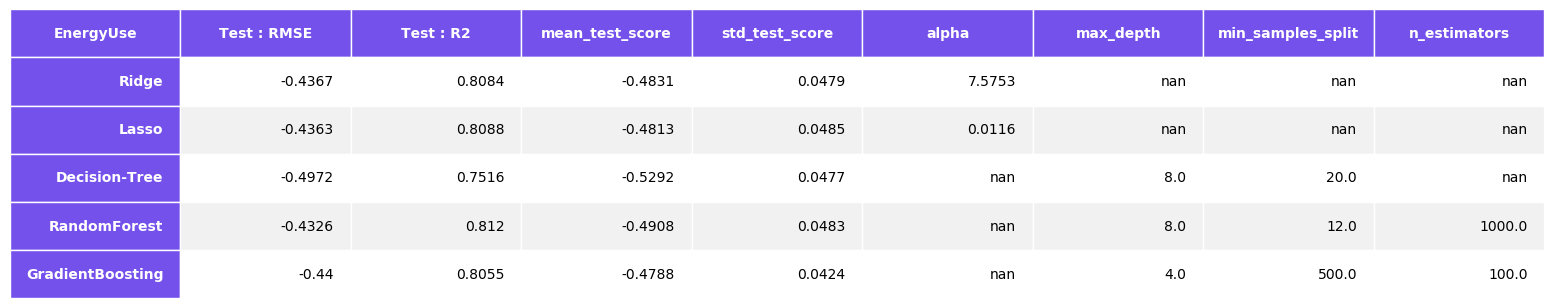

In [13]:
# Je définis mes régresseurs ainsi que la plage de leurs hyperparamètres respectifs.
regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('Decision-Tree', DecisionTreeRegressor(random_state=seed), [{'max_depth': [4, 8, 12],
                                                                            'min_samples_split': [20, 50, 100]}]),

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [8, 10, 12], 
                                                                           'min_samples_split': [10, 12, 14],
                                                                           'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8,], 
                                                                                   'min_samples_split': [200, 500, 1000], 
                                                                                   'n_estimators': [50, 100, 200]}])]

evaluate_estimators(X_train, X_test, y_train, y_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='EnergyUse')

Info : Pour la suite du notebook, les blocs de segmentation, de features selection et d'évaluation de modèles seront tous dans une cellule.

---
# 4. Modélisation : Emissions carbone

Ridge en cours d'exécution...
Lasso en cours d'exécution...
Decision-Tree en cours d'exécution...
RandomForest en cours d'exécution...
GradientBoosting en cours d'exécution...


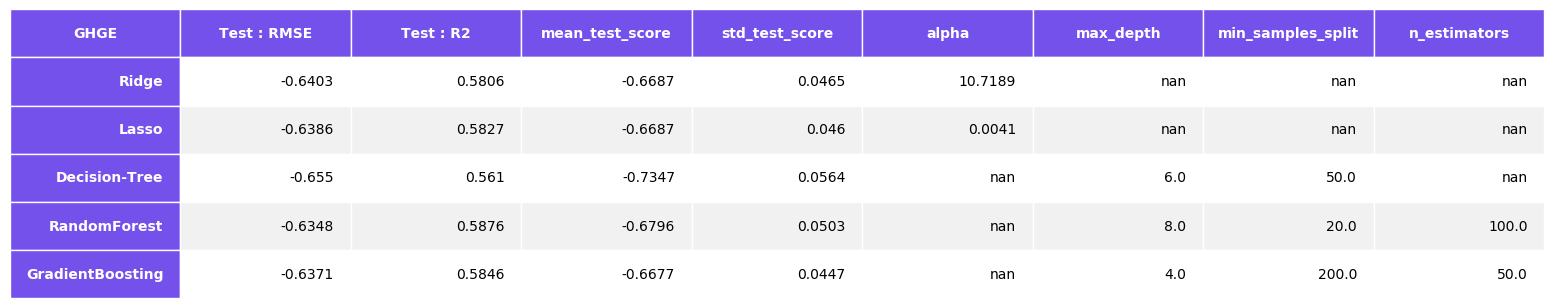

In [14]:
# Segmentation des données d'entrainement et des données de test
X = std_buildings.drop(['SiteEnergyUse(kBtu)_log', 'GHGEmissions(MetricTonsCO2e)_log'], axis=1)
y = std_buildings['GHGEmissions(MetricTonsCO2e)_log']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Je sélectione mes features
lcv = LassoCV()
lcv.fit(X_train, y_train)
lcv_mask = lcv.coef_ != 0

rfe_rf = RFE(estimator=RandomForestRegressor(), n_features_to_select=12, step=1, verbose=1)
rfe_rf.fit(X_train, y_train)
rf_mask = rfe_rf.support_

rfe_gb = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=12, step=1, verbose=1)
rfe_gb.fit(X_train, y_train)
gb_mask = rfe_gb.support_

votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

mask = votes >= 2
X_train = X_train.loc[:, mask]

# Je définis mes régresseurs ainsi que la plage de leurs hyperparamètres respectifs.
regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('Decision-Tree', DecisionTreeRegressor(random_state=seed), [{'max_depth': [4, 6, 8],
                                                                            'min_samples_split': [20, 50, 100]}]),

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [6, 8, 10], 
                                                                           'min_samples_split': [10, 20, 50],
                                                                           'n_estimators': [50, 100, 200]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8], 
                                                                                   'min_samples_split': [50, 100, 200], 
                                                                                   'n_estimators': [50, 100, 200]}])]

# J'appelle ma fonction maison
evaluate_estimators(X_train, X_test, y_train, y_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='GHGE')


---
# 5. Evaluation de l'intérêt d'ENERGYSTARScore dans la prédiction des émissions carbone

Ridge en cours d'exécution...
Lasso en cours d'exécution...
Decision-Tree en cours d'exécution...
RandomForest en cours d'exécution...
GradientBoosting en cours d'exécution...


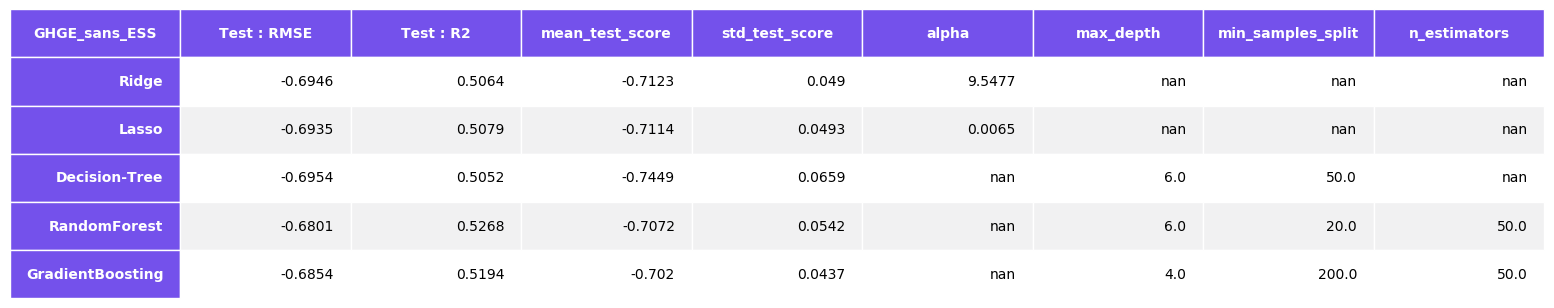

In [15]:
# Segmentation des données d'entrainement et des données de test
X = std_buildings.drop(['SiteEnergyUse(kBtu)_log', 'GHGEmissions(MetricTonsCO2e)_log', 'Binned_ENERGYSTARScore'], axis=1)
y = std_buildings['GHGEmissions(MetricTonsCO2e)_log']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Features Selection
lcv = LassoCV()
lcv.fit(X_train, y_train)
lcv_mask = lcv.coef_ != 0

rfe_rf = RFE(estimator=RandomForestRegressor(), n_features_to_select=13, step=1, verbose=1)
rfe_rf.fit(X_train, y_train)
rf_mask = rfe_rf.support_

rfe_gb = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=13, step=1, verbose=1)
rfe_gb.fit(X_train, y_train)
gb_mask = rfe_gb.support_

votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

mask = votes >= 2
X_train = X_train.loc[:, mask]

# Je définis mes régresseurs ainsi que la plage de leurs hyperparamètres respectifs.
regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('Decision-Tree', DecisionTreeRegressor(random_state=seed), [{'max_depth': [4, 6, 8],
                                                                            'min_samples_split': [20, 50, 100]}]),

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [6, 8, 10], 
                                                                           'min_samples_split': [10, 20, 50],
                                                                           'n_estimators': [50, 100, 200]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8], 
                                                                                   'min_samples_split': [50, 100, 200], 
                                                                                   'n_estimators': [50, 100, 200]}])]

# J'appelle ma fonction maison
evaluate_estimators(X_train, X_test, y_train, y_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='GHGE_sans_ESS')

---
# 6. Choix des modèles

### Consommation d'énergie
Le modèle qui a le meilleur RMSE (0,43) est **RandomForest** sur les données de test, c'est à dire sur des données que le modèle n'a jamais vu. Il présente un r2 correct (0.81). Cela signifie qu'il est correctement ajusté, c'est à dire que le modèle n'est pas sous ajusté, ni surajusté.

### Emission carbone
Le modèle qui a le meilleur RMSE (0,63) sur les données de test, est encore **RandomForest**. Il présente un r2 un peu faible à mon sens (0.59). Cela signifie qu'il peut-être potentiellement sous-ajusté.

### Intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions carbone
En écartant la variable représentant l'Energy Star Score des features des prédictions des émissions carbones, le modèle qui a le meilleur RMSE (0,68) sur les données de test, est **RandomForest**. Il présente un r2 trop faible pour être mis en production (0.52). Cela signifie que le modèle est clairement sous-ajusté.

### Conclusion
Le modèle prédictif sur la consommation d'énergie est au point. Le modèle prédictif sur les émissions carbone tendrait à être optimisé avec de nouvelles variables. Les variables dont nous disposons impactent plus la consommation d'energie que les émissions carbone. 
Au vu des résultats du modèle prédictif sans la variable Energy Star Score, il est difficile de se passer de cette variable. Je recommande son utilisation.


---
---
# Annexe - Détail de la fonction evaluate_estimators()

In [ ]:
def evaluate_estimators(X_train, X_test, y_train, y_test, estimators, cv=5, scoring='neg_root_mean_squared_error', target_name='target'):
    """Evalue les modèles en estimant les meilleurs hyperparamètres. Crée un PNG des résultats.

    Args:
        X_train (object): Données d'entrainements
        X_test (object): Données de tests
        y_train (object): Données d'entrainements
        y_test (object): Données de tests
        estimators (dict): Contient les modèles et les hyperparamètres à tester
        cv (int, optional): Nombre de cross-validation. Defaults to 5.
        scoring (str, optional): Métrique d'évaluation des modèles. Defaults to 'neg_root_mean_squared_error'.
        target_name (str, optional): Nom de la cible. Defaults to 'target'.

    Returns:
        None
    """
    
    results = pd.DataFrame()
    for estim_name, estim, estim_params in estimators:
        print(f"{estim_name} en cours d'exécution...")
        model = GridSearchCV(estim, param_grid=estim_params, cv=cv, scoring=scoring, n_jobs=4)
        model.fit(X_train, y_train)

        # Je stocke les résultats du GridSearchCV dans un dataframe
        model_results_df = pd.DataFrame(model.cv_results_)

        # Je sélectionne la meilleure observations
        model_results_df = model_results_df[model_results_df["rank_test_score"] == 1]

        # J'ajoute le nom du modéle et les résultats sur les données de test
        model_results_df[target_name] = estim_name
        model_results_df['Test : R2'] = r2_score(y_test, model.predict(X_test))
        model_results_df['Test : RMSE'] = model.score(X_test, y_test)


        # Les hyperparamètres des estimateurs étant changeant, je crée un nouveau dataframe à partir de la colonne params           des résultats. Je jointe les 2 dataframes à partir des index. Cela me permet des flexible pour mon dataframe.
        model_results_df = pd.merge(model_results_df[[target_name,'Test : RMSE', 'Test : R2', 'mean_test_score', 'std_test_score']], 
                                 pd.DataFrame(model.cv_results_['params']), 
                                 left_index=True, right_index=True)
    
        # Je stocke les résultats dans un nouveau dataframe.
        results = results.append(model_results_df)
    
    export_png_table(round(results,4), filename='img_results_' + target_name + '.png')

    return None